In [1]:
!nvidia-smi

Thu Aug  8 08:40:34 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# Setting our $HOME to /content

import os
HOME = os.getcwd()
print(HOME)

/content


In [3]:
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    print("Google Drive is mounted.")
else:
    print("You aren't in Google Colab.")


Mounted at /content/drive
Google Drive is mounted.


## 2. Load a dataset (dataloader)

Create the dataset directory (if it doesn't exist), where we are going to save the dataset with which we are going to train our CNN.

---
**Create a directory where we can save our dataset**

---

In [4]:
import os
datasets_dir = os.path.join(HOME, "datasets")
os.makedirs(datasets_dir, exist_ok=True)
print(os.getcwd())

/content


---
**Change to new directory datasets**

---

In [5]:
%%time

# Change to new datasets folder
os.chdir(datasets_dir)
print('dataset_dir =', os.getcwd())
if  not os.path.isfile('exp4val.zip'):
  !wget -q https://www.dropbox.com/s/nzrvuoos7sgl5dh/exp4val.zip
  !unzip -qq -o exp4val.zip

dataset_dir = /content/datasets
CPU times: user 58.6 ms, sys: 14.7 ms, total: 73.3 ms
Wall time: 9.35 s


### Inspect the Dataset: Skin lesion recognition in 7 classes:

*  0: 'akiec' - actinic keratosis

*  1: 'bcc' - basal cell carcinoma

*  2: 'bkl' - benign keratosis

*  3: 'df' - dermatofibroma

*  4: 'mel' - melanoma

*  5: 'nv' - melanocytic nevus

*  6: 'vasc' - vascular lesion


The dataset contains several thousand photos of cell images in seven subdirectories (classes) with one cell image per class. The directory structure is as follows thanks to this snipet:

---
**Display the datapath structure.**

---

In [6]:
import os

def print_directory_tree(root_dir, level=0):
    """
    Recursively prints the directory tree structure, only listing directories.
    """
    prefix = " " * (level * 4) + "|-- " if level > 0 else ""
    print(prefix + os.path.basename(root_dir))

    if os.path.isdir(root_dir):
        for item in os.listdir(root_dir):
            item_path = os.path.join(root_dir, item)
            if os.path.isdir(item_path):
                print_directory_tree(item_path, level + 1)

# Define the data directory
data_dir = datasets_dir

# Print the directory tree
print_directory_tree(data_dir)

datasets
    |-- __MACOSX
        |-- train
            |-- class_1
            |-- class_2
            |-- class_0
            |-- class_3
            |-- class_6
            |-- class_4
            |-- class_5
        |-- val
            |-- class_0
        |-- test
            |-- class_1
    |-- train
        |-- class_1
        |-- class_2
        |-- class_0
        |-- class_3
        |-- class_6
        |-- class_4
        |-- class_5
    |-- val
        |-- class_1
        |-- class_2
        |-- class_0
        |-- class_3
        |-- class_6
        |-- class_4
        |-- class_5
    |-- test
        |-- class_1
        |-- class_2
        |-- class_0
        |-- class_3
        |-- class_6
        |-- class_4
        |-- class_5



---
**Display 8 images from a class from test**

---

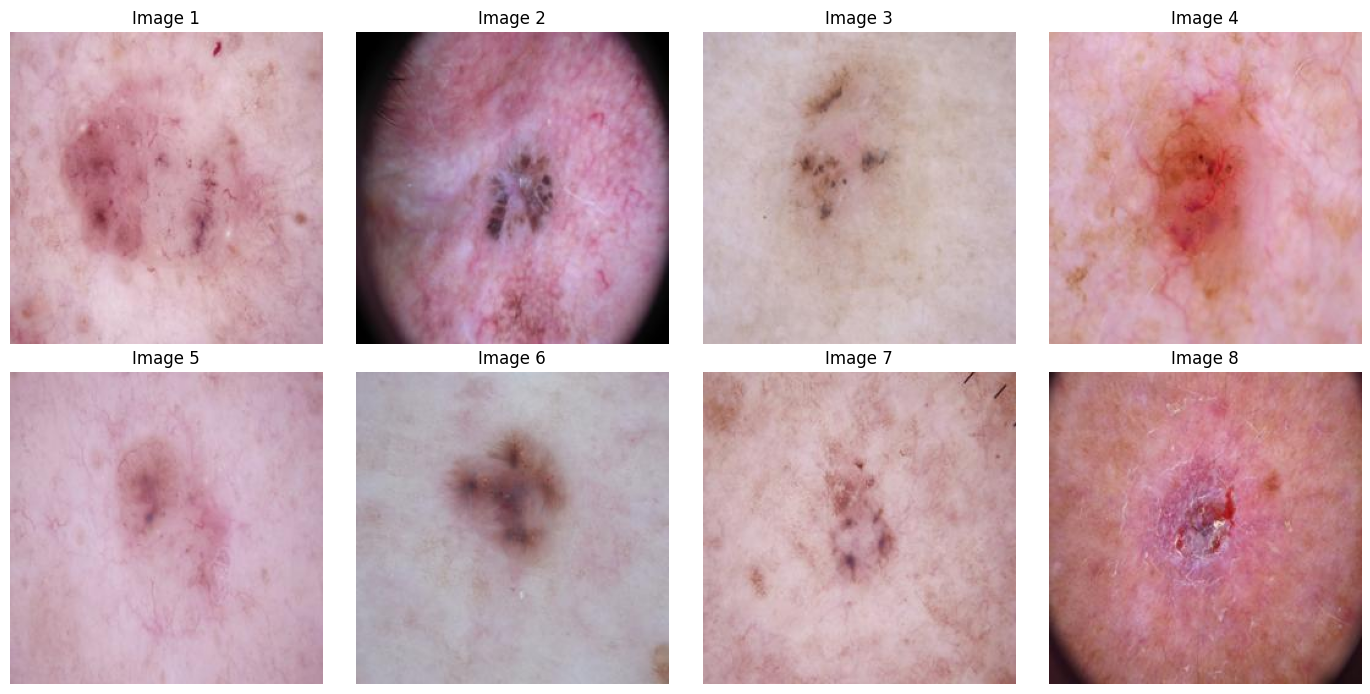


 Size of image:  (256, 256, 3)


In [7]:
# creates a figure with subplots arranged in a 2x4 grid
import matplotlib.pyplot as plt
import glob
import matplotlib.image as mpimg

# Directory of the images
image_directory = f'{HOME}/datasets/test/class_1/'

# List of image paths
image_paths = glob.glob(image_directory + '*.jpg')[:8]

# Set up the figure with subplots
fig, axs = plt.subplots(2, 4, figsize=(14, 7))

# Iterate through the images and display them in the subplots
for i, image_path in enumerate(image_paths):
    row = i // 4
    col = i % 4
    img = mpimg.imread(image_path)
    axs[row, col].imshow(img)
    axs[row, col].set_title(f'Image {i + 1}')
    axs[row, col].axis('off')

# Adjust the layout of the subplots
plt.tight_layout()
plt.show()
print("\n Size of image: ", img.shape)

---
**Data augmentation**

---

In [8]:
from torchvision import datasets, models, transforms

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

---
**Dataloaders**

---

In [9]:
import torch
from torch.utils.data import DataLoader

# Configuraciones
data_dir = f'{HOME}/datasets'
num_classes = 7
batch_size = 32
num_epochs = 50
feature_extract = True


image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size,
                             shuffle=True, num_workers=2)
               for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
import torch.nn as nn
import torch.optim as optim

# Función para establecer los parámetros de entrenamiento
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

# Inicializar el modelo de ResNet50
def initialize_model(num_classes, feature_extract, use_pretrained=True):
    model_ft = models.resnet50(weights=models.ResNet50_Weights.DEFAULT if use_pretrained else None)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)
    return model_ft

model_ft = initialize_model(num_classes, feature_extract, use_pretrained=True)
model_ft = model_ft.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 137MB/s]


In [18]:
!pip install -q torchinfo

In [20]:
import torchinfo

# Print a summary using torchinfo (uncomment for actual output)
torchinfo.summary(model=model_ft,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 7]              --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (4,096)              False
│    │    

In [11]:
# Configuración del optimizador
params_to_update = model_ft.parameters()
if feature_extract:
    params_to_update = [param for param in model_ft.parameters() if param.requires_grad]

optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()


In [12]:
from tqdm import tqdm

def train_model(model, dataloaders, criterion, optimizer, num_epochs=num_epochs):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Listas para almacenar las métricas
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Usar tqdm para la barra de progreso
            with tqdm(dataloaders[phase], unit="batch") as tepoch:
                for inputs, labels in tepoch:
                    tepoch.set_description(f"Phase {phase} Epoch {epoch+1}/{num_epochs}")

                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                    # Actualiza la barra de progreso con la pérdida y la precisión
                    tepoch.set_postfix(loss=loss.item(), accuracy=torch.sum(preds == labels.data).item()/inputs.size(0))

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Almacenar las métricas
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.item())

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    print(f'Best val Acc: {best_acc:4f}')
    model.load_state_dict(best_model_wts)

    return model, train_losses, val_losses, train_accuracies, val_accuracies

In [13]:
# Entrenar el modelo
import copy
model_ft, train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model_ft, dataloaders, criterion, optimizer_ft, num_epochs=num_epochs
)

# Guardar el modelo
torch.save(model_ft.state_dict(), 'best_model.pth')

# Evaluar el modelo en el conjunto de prueba
model_ft.eval()
running_corrects = 0

Epoch 1/50
----------


Phase train Epoch 1/50: 100%|██████████| 230/230 [00:32<00:00,  7.06batch/s, accuracy=0.318, loss=1.77]


train Loss: 1.7294 Acc: 0.3829


Phase val Epoch 1/50: 100%|██████████| 33/33 [00:03<00:00,  8.94batch/s, accuracy=0.385, loss=1.48]


val Loss: 1.5920 Acc: 0.4714

Epoch 2/50
----------


Phase train Epoch 2/50: 100%|██████████| 230/230 [00:31<00:00,  7.20batch/s, accuracy=0.409, loss=1.42]


train Loss: 1.4898 Acc: 0.4970


Phase val Epoch 2/50: 100%|██████████| 33/33 [00:03<00:00,  8.26batch/s, accuracy=0.5, loss=1.58]


val Loss: 1.4468 Acc: 0.4962

Epoch 3/50
----------


Phase train Epoch 3/50: 100%|██████████| 230/230 [00:30<00:00,  7.44batch/s, accuracy=0.545, loss=1.4]


train Loss: 1.3857 Acc: 0.5184


Phase val Epoch 3/50: 100%|██████████| 33/33 [00:03<00:00,  8.73batch/s, accuracy=0.385, loss=1.39]


val Loss: 1.3676 Acc: 0.5152

Epoch 4/50
----------


Phase train Epoch 4/50: 100%|██████████| 230/230 [00:32<00:00,  6.99batch/s, accuracy=0.591, loss=1.4]


train Loss: 1.3207 Acc: 0.5350


Phase val Epoch 4/50: 100%|██████████| 33/33 [00:04<00:00,  7.53batch/s, accuracy=0.692, loss=1.27]


val Loss: 1.3334 Acc: 0.5400

Epoch 5/50
----------


Phase train Epoch 5/50: 100%|██████████| 230/230 [00:31<00:00,  7.38batch/s, accuracy=0.591, loss=1.18]


train Loss: 1.2812 Acc: 0.5457


Phase val Epoch 5/50: 100%|██████████| 33/33 [00:03<00:00,  8.46batch/s, accuracy=0.5, loss=1.4]


val Loss: 1.3037 Acc: 0.5314

Epoch 6/50
----------


Phase train Epoch 6/50: 100%|██████████| 230/230 [00:31<00:00,  7.38batch/s, accuracy=0.5, loss=1.26]


train Loss: 1.2485 Acc: 0.5608


Phase val Epoch 6/50: 100%|██████████| 33/33 [00:03<00:00,  8.96batch/s, accuracy=0.5, loss=1.19]


val Loss: 1.2727 Acc: 0.5476

Epoch 7/50
----------


Phase train Epoch 7/50: 100%|██████████| 230/230 [00:30<00:00,  7.45batch/s, accuracy=0.409, loss=1.53]


train Loss: 1.2272 Acc: 0.5667


Phase val Epoch 7/50: 100%|██████████| 33/33 [00:04<00:00,  8.00batch/s, accuracy=0.615, loss=1.1]


val Loss: 1.2504 Acc: 0.5524

Epoch 8/50
----------


Phase train Epoch 8/50: 100%|██████████| 230/230 [00:30<00:00,  7.46batch/s, accuracy=0.455, loss=1.46]


train Loss: 1.2009 Acc: 0.5721


Phase val Epoch 8/50: 100%|██████████| 33/33 [00:03<00:00,  8.28batch/s, accuracy=0.654, loss=0.984]


val Loss: 1.2391 Acc: 0.5552

Epoch 9/50
----------


Phase train Epoch 9/50: 100%|██████████| 230/230 [00:30<00:00,  7.53batch/s, accuracy=0.682, loss=1.08]


train Loss: 1.1852 Acc: 0.5771


Phase val Epoch 9/50: 100%|██████████| 33/33 [00:03<00:00,  8.84batch/s, accuracy=0.5, loss=1.35]


val Loss: 1.1957 Acc: 0.5886

Epoch 10/50
----------


Phase train Epoch 10/50: 100%|██████████| 230/230 [00:32<00:00,  7.13batch/s, accuracy=0.727, loss=0.763]


train Loss: 1.1658 Acc: 0.5880


Phase val Epoch 10/50: 100%|██████████| 33/33 [00:04<00:00,  8.24batch/s, accuracy=0.538, loss=1.3]


val Loss: 1.1871 Acc: 0.5819

Epoch 11/50
----------


Phase train Epoch 11/50: 100%|██████████| 230/230 [00:30<00:00,  7.43batch/s, accuracy=0.591, loss=1.33]


train Loss: 1.1522 Acc: 0.5922


Phase val Epoch 11/50: 100%|██████████| 33/33 [00:04<00:00,  8.06batch/s, accuracy=0.731, loss=0.977]


val Loss: 1.1782 Acc: 0.5733

Epoch 12/50
----------


Phase train Epoch 12/50: 100%|██████████| 230/230 [00:30<00:00,  7.57batch/s, accuracy=0.409, loss=1.61]


train Loss: 1.1520 Acc: 0.5901


Phase val Epoch 12/50: 100%|██████████| 33/33 [00:03<00:00,  8.95batch/s, accuracy=0.5, loss=1.13]


val Loss: 1.1790 Acc: 0.5714

Epoch 13/50
----------


Phase train Epoch 13/50: 100%|██████████| 230/230 [00:30<00:00,  7.49batch/s, accuracy=0.636, loss=1.16]


train Loss: 1.1364 Acc: 0.5954


Phase val Epoch 13/50: 100%|██████████| 33/33 [00:03<00:00,  8.84batch/s, accuracy=0.538, loss=1.13]


val Loss: 1.1482 Acc: 0.5962

Epoch 14/50
----------


Phase train Epoch 14/50: 100%|██████████| 230/230 [00:33<00:00,  6.93batch/s, accuracy=0.636, loss=0.943]


train Loss: 1.1204 Acc: 0.6020


Phase val Epoch 14/50: 100%|██████████| 33/33 [00:04<00:00,  7.96batch/s, accuracy=0.538, loss=1.1]


val Loss: 1.1434 Acc: 0.6038

Epoch 15/50
----------


Phase train Epoch 15/50: 100%|██████████| 230/230 [00:31<00:00,  7.33batch/s, accuracy=0.545, loss=1.15]


train Loss: 1.1017 Acc: 0.6069


Phase val Epoch 15/50: 100%|██████████| 33/33 [00:03<00:00,  8.87batch/s, accuracy=0.731, loss=0.884]


val Loss: 1.1276 Acc: 0.6019

Epoch 16/50
----------


Phase train Epoch 16/50: 100%|██████████| 230/230 [00:31<00:00,  7.24batch/s, accuracy=0.591, loss=1.21]


train Loss: 1.1123 Acc: 0.6005


Phase val Epoch 16/50: 100%|██████████| 33/33 [00:03<00:00,  8.48batch/s, accuracy=0.769, loss=0.92]


val Loss: 1.1506 Acc: 0.6067

Epoch 17/50
----------


Phase train Epoch 17/50: 100%|██████████| 230/230 [00:31<00:00,  7.37batch/s, accuracy=0.545, loss=1.27]


train Loss: 1.0886 Acc: 0.6163


Phase val Epoch 17/50: 100%|██████████| 33/33 [00:05<00:00,  6.13batch/s, accuracy=0.5, loss=1.23]


val Loss: 1.1075 Acc: 0.6010

Epoch 18/50
----------


Phase train Epoch 18/50: 100%|██████████| 230/230 [00:36<00:00,  6.38batch/s, accuracy=0.636, loss=1.12]


train Loss: 1.0815 Acc: 0.6173


Phase val Epoch 18/50: 100%|██████████| 33/33 [00:04<00:00,  7.96batch/s, accuracy=0.692, loss=1.02]


val Loss: 1.0977 Acc: 0.6181

Epoch 19/50
----------


Phase train Epoch 19/50: 100%|██████████| 230/230 [00:32<00:00,  7.15batch/s, accuracy=0.5, loss=1.37]


train Loss: 1.0787 Acc: 0.6162


Phase val Epoch 19/50: 100%|██████████| 33/33 [00:03<00:00,  8.27batch/s, accuracy=0.5, loss=1.21]


val Loss: 1.1188 Acc: 0.6124

Epoch 20/50
----------


Phase train Epoch 20/50: 100%|██████████| 230/230 [00:32<00:00,  7.14batch/s, accuracy=0.591, loss=1.24]


train Loss: 1.0726 Acc: 0.6188


Phase val Epoch 20/50: 100%|██████████| 33/33 [00:03<00:00,  8.82batch/s, accuracy=0.692, loss=1.15]


val Loss: 1.0866 Acc: 0.6171

Epoch 21/50
----------


Phase train Epoch 21/50: 100%|██████████| 230/230 [00:32<00:00,  7.06batch/s, accuracy=0.5, loss=1.17]


train Loss: 1.0701 Acc: 0.6173


Phase val Epoch 21/50: 100%|██████████| 33/33 [00:04<00:00,  7.31batch/s, accuracy=0.615, loss=1.03]


val Loss: 1.1045 Acc: 0.6038

Epoch 22/50
----------


Phase train Epoch 22/50: 100%|██████████| 230/230 [00:32<00:00,  7.17batch/s, accuracy=0.545, loss=0.972]


train Loss: 1.0675 Acc: 0.6207


Phase val Epoch 22/50: 100%|██████████| 33/33 [00:03<00:00,  8.78batch/s, accuracy=0.692, loss=0.935]


val Loss: 1.0800 Acc: 0.6200

Epoch 23/50
----------


Phase train Epoch 23/50: 100%|██████████| 230/230 [00:31<00:00,  7.38batch/s, accuracy=0.5, loss=1.18]


train Loss: 1.0474 Acc: 0.6246


Phase val Epoch 23/50: 100%|██████████| 33/33 [00:03<00:00,  8.63batch/s, accuracy=0.731, loss=1.11]


val Loss: 1.0747 Acc: 0.6257

Epoch 24/50
----------


Phase train Epoch 24/50: 100%|██████████| 230/230 [00:34<00:00,  6.58batch/s, accuracy=0.727, loss=0.997]


train Loss: 1.0403 Acc: 0.6314


Phase val Epoch 24/50: 100%|██████████| 33/33 [00:03<00:00,  8.44batch/s, accuracy=0.615, loss=0.97]


val Loss: 1.0760 Acc: 0.6229

Epoch 25/50
----------


Phase train Epoch 25/50: 100%|██████████| 230/230 [00:32<00:00,  7.04batch/s, accuracy=0.455, loss=1.51]


train Loss: 1.0388 Acc: 0.6359


Phase val Epoch 25/50: 100%|██████████| 33/33 [00:03<00:00,  8.87batch/s, accuracy=0.577, loss=1.07]


val Loss: 1.0545 Acc: 0.6181

Epoch 26/50
----------


Phase train Epoch 26/50: 100%|██████████| 230/230 [00:32<00:00,  7.02batch/s, accuracy=0.682, loss=1.18]


train Loss: 1.0402 Acc: 0.6275


Phase val Epoch 26/50: 100%|██████████| 33/33 [00:04<00:00,  7.24batch/s, accuracy=0.808, loss=0.82]


val Loss: 1.0690 Acc: 0.6267

Epoch 27/50
----------


Phase train Epoch 27/50: 100%|██████████| 230/230 [00:31<00:00,  7.39batch/s, accuracy=0.545, loss=1.13]


train Loss: 1.0214 Acc: 0.6346


Phase val Epoch 27/50: 100%|██████████| 33/33 [00:03<00:00,  8.86batch/s, accuracy=0.538, loss=1.13]


val Loss: 1.0564 Acc: 0.6267

Epoch 28/50
----------


Phase train Epoch 28/50: 100%|██████████| 230/230 [00:33<00:00,  6.93batch/s, accuracy=0.727, loss=0.877]


train Loss: 1.0242 Acc: 0.6309


Phase val Epoch 28/50: 100%|██████████| 33/33 [00:04<00:00,  8.03batch/s, accuracy=0.538, loss=1.29]


val Loss: 1.0620 Acc: 0.6038

Epoch 29/50
----------


Phase train Epoch 29/50: 100%|██████████| 230/230 [00:31<00:00,  7.29batch/s, accuracy=0.682, loss=0.748]


train Loss: 1.0194 Acc: 0.6362


Phase val Epoch 29/50: 100%|██████████| 33/33 [00:03<00:00,  8.29batch/s, accuracy=0.538, loss=1.25]


val Loss: 1.0619 Acc: 0.6181

Epoch 30/50
----------


Phase train Epoch 30/50: 100%|██████████| 230/230 [00:31<00:00,  7.34batch/s, accuracy=0.727, loss=0.792]


train Loss: 1.0175 Acc: 0.6412


Phase val Epoch 30/50: 100%|██████████| 33/33 [00:03<00:00,  8.81batch/s, accuracy=0.769, loss=0.943]


val Loss: 1.0751 Acc: 0.6248

Epoch 31/50
----------


Phase train Epoch 31/50: 100%|██████████| 230/230 [00:31<00:00,  7.27batch/s, accuracy=0.773, loss=0.966]


train Loss: 1.0034 Acc: 0.6480


Phase val Epoch 31/50: 100%|██████████| 33/33 [00:04<00:00,  7.92batch/s, accuracy=0.538, loss=1.28]


val Loss: 1.0537 Acc: 0.6267

Epoch 32/50
----------


Phase train Epoch 32/50: 100%|██████████| 230/230 [00:33<00:00,  6.91batch/s, accuracy=0.591, loss=0.956]


train Loss: 1.0171 Acc: 0.6396


Phase val Epoch 32/50: 100%|██████████| 33/33 [00:03<00:00,  8.67batch/s, accuracy=0.731, loss=0.81]


val Loss: 1.0528 Acc: 0.6267

Epoch 33/50
----------


Phase train Epoch 33/50: 100%|██████████| 230/230 [00:32<00:00,  7.09batch/s, accuracy=0.636, loss=1.22]


train Loss: 1.0002 Acc: 0.6483


Phase val Epoch 33/50: 100%|██████████| 33/33 [00:03<00:00,  8.84batch/s, accuracy=0.577, loss=1.17]


val Loss: 1.0506 Acc: 0.6200

Epoch 34/50
----------


Phase train Epoch 34/50: 100%|██████████| 230/230 [00:32<00:00,  7.02batch/s, accuracy=0.5, loss=1.25]


train Loss: 0.9931 Acc: 0.6426


Phase val Epoch 34/50: 100%|██████████| 33/33 [00:04<00:00,  7.77batch/s, accuracy=0.577, loss=1.13]


val Loss: 1.0392 Acc: 0.6248

Epoch 35/50
----------


Phase train Epoch 35/50: 100%|██████████| 230/230 [00:31<00:00,  7.41batch/s, accuracy=0.682, loss=1.03]


train Loss: 0.9905 Acc: 0.6506


Phase val Epoch 35/50: 100%|██████████| 33/33 [00:03<00:00,  8.86batch/s, accuracy=0.769, loss=0.77]


val Loss: 1.0250 Acc: 0.6343

Epoch 36/50
----------


Phase train Epoch 36/50: 100%|██████████| 230/230 [00:31<00:00,  7.35batch/s, accuracy=0.636, loss=0.992]


train Loss: 0.9911 Acc: 0.6551


Phase val Epoch 36/50: 100%|██████████| 33/33 [00:03<00:00,  8.66batch/s, accuracy=0.731, loss=0.778]


val Loss: 1.0423 Acc: 0.6362

Epoch 37/50
----------


Phase train Epoch 37/50: 100%|██████████| 230/230 [00:32<00:00,  7.06batch/s, accuracy=0.5, loss=1.4]


train Loss: 0.9923 Acc: 0.6480


Phase val Epoch 37/50: 100%|██████████| 33/33 [00:04<00:00,  7.85batch/s, accuracy=0.654, loss=1.07]


val Loss: 1.0215 Acc: 0.6305

Epoch 38/50
----------


Phase train Epoch 38/50: 100%|██████████| 230/230 [00:31<00:00,  7.41batch/s, accuracy=0.591, loss=1.11]


train Loss: 0.9829 Acc: 0.6487


Phase val Epoch 38/50: 100%|██████████| 33/33 [00:03<00:00,  8.88batch/s, accuracy=0.808, loss=0.719]


val Loss: 1.0180 Acc: 0.6295

Epoch 39/50
----------


Phase train Epoch 39/50: 100%|██████████| 230/230 [00:31<00:00,  7.34batch/s, accuracy=0.727, loss=1]


train Loss: 0.9873 Acc: 0.6471


Phase val Epoch 39/50: 100%|██████████| 33/33 [00:03<00:00,  8.69batch/s, accuracy=0.692, loss=1.1]


val Loss: 1.0162 Acc: 0.6219

Epoch 40/50
----------


Phase train Epoch 40/50: 100%|██████████| 230/230 [00:32<00:00,  7.18batch/s, accuracy=0.636, loss=1.05]


train Loss: 0.9723 Acc: 0.6570


Phase val Epoch 40/50: 100%|██████████| 33/33 [00:04<00:00,  7.69batch/s, accuracy=0.615, loss=0.902]


val Loss: 1.0160 Acc: 0.6257

Epoch 41/50
----------


Phase train Epoch 41/50: 100%|██████████| 230/230 [00:31<00:00,  7.41batch/s, accuracy=0.545, loss=1.21]


train Loss: 0.9793 Acc: 0.6548


Phase val Epoch 41/50: 100%|██████████| 33/33 [00:03<00:00,  8.96batch/s, accuracy=0.692, loss=0.906]


val Loss: 1.0145 Acc: 0.6371

Epoch 42/50
----------


Phase train Epoch 42/50: 100%|██████████| 230/230 [00:31<00:00,  7.36batch/s, accuracy=0.727, loss=1.07]


train Loss: 0.9794 Acc: 0.6552


Phase val Epoch 42/50: 100%|██████████| 33/33 [00:03<00:00,  8.44batch/s, accuracy=0.615, loss=1.1]


val Loss: 1.0177 Acc: 0.6410

Epoch 43/50
----------


Phase train Epoch 43/50: 100%|██████████| 230/230 [00:31<00:00,  7.27batch/s, accuracy=0.773, loss=0.683]


train Loss: 0.9734 Acc: 0.6539


Phase val Epoch 43/50: 100%|██████████| 33/33 [00:04<00:00,  7.93batch/s, accuracy=0.731, loss=1.07]


val Loss: 1.0208 Acc: 0.6371

Epoch 44/50
----------


Phase train Epoch 44/50: 100%|██████████| 230/230 [00:31<00:00,  7.22batch/s, accuracy=0.727, loss=0.857]


train Loss: 0.9673 Acc: 0.6593


Phase val Epoch 44/50: 100%|██████████| 33/33 [00:03<00:00,  8.81batch/s, accuracy=0.615, loss=1.05]


val Loss: 1.0140 Acc: 0.6352

Epoch 45/50
----------


Phase train Epoch 45/50: 100%|██████████| 230/230 [00:32<00:00,  7.02batch/s, accuracy=0.773, loss=0.754]


train Loss: 0.9620 Acc: 0.6576


Phase val Epoch 45/50: 100%|██████████| 33/33 [00:04<00:00,  7.59batch/s, accuracy=0.615, loss=1.09]


val Loss: 1.0152 Acc: 0.6371

Epoch 46/50
----------


Phase train Epoch 46/50: 100%|██████████| 230/230 [00:32<00:00,  7.04batch/s, accuracy=0.591, loss=1.02]


train Loss: 0.9651 Acc: 0.6556


Phase val Epoch 46/50: 100%|██████████| 33/33 [00:03<00:00,  8.89batch/s, accuracy=0.731, loss=0.987]


val Loss: 1.0020 Acc: 0.6448

Epoch 47/50
----------


Phase train Epoch 47/50: 100%|██████████| 230/230 [00:31<00:00,  7.33batch/s, accuracy=0.636, loss=0.805]


train Loss: 0.9612 Acc: 0.6527


Phase val Epoch 47/50: 100%|██████████| 33/33 [00:03<00:00,  8.80batch/s, accuracy=0.692, loss=0.894]


val Loss: 1.0058 Acc: 0.6333

Epoch 48/50
----------


Phase train Epoch 48/50:  98%|█████████▊| 225/230 [00:31<00:00,  7.03batch/s, accuracy=0.75, loss=0.942]


train Loss: 0.9612 Acc: 0.6631


Phase val Epoch 48/50: 100%|██████████| 33/33 [00:04<00:00,  7.51batch/s, accuracy=0.731, loss=0.924]


val Loss: 1.0073 Acc: 0.6286

Epoch 49/50
----------


Phase train Epoch 49/50: 100%|██████████| 230/230 [00:31<00:00,  7.19batch/s, accuracy=0.682, loss=0.975]


train Loss: 0.9628 Acc: 0.6543


Phase val Epoch 49/50: 100%|██████████| 33/33 [00:03<00:00,  8.80batch/s, accuracy=0.615, loss=0.846]


val Loss: 1.0066 Acc: 0.6362

Epoch 50/50
----------


Phase train Epoch 50/50: 100%|██████████| 230/230 [00:31<00:00,  7.20batch/s, accuracy=0.5, loss=1.15]


train Loss: 0.9593 Acc: 0.6561


Phase val Epoch 50/50: 100%|██████████| 33/33 [00:04<00:00,  8.24batch/s, accuracy=0.769, loss=0.715]


val Loss: 1.0024 Acc: 0.6314

Best val Acc: 0.644762


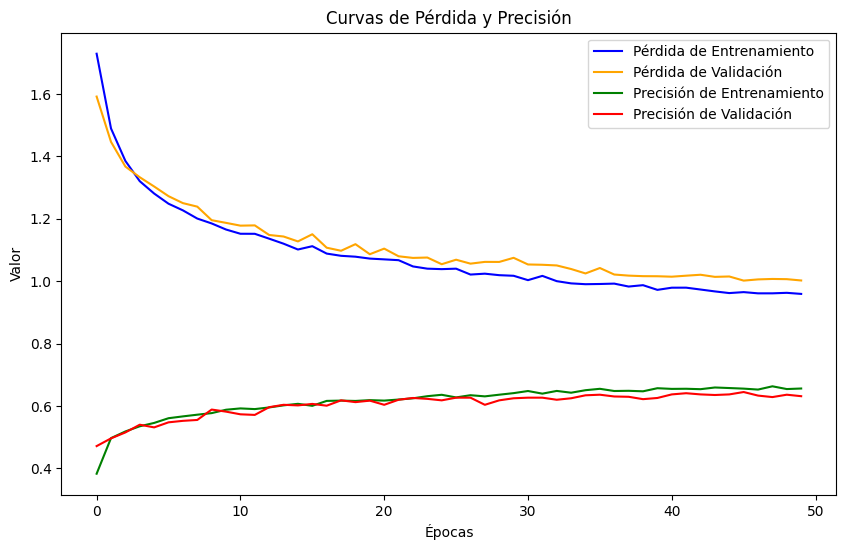

In [15]:
import matplotlib.pyplot as plt

# Crear un solo subplot en una figura
fig, ax = plt.subplots(figsize=(10, 6))

# Graficar las curvas de pérdida
ax.plot(train_losses, label="Pérdida de Entrenamiento", color='blue')
ax.plot(val_losses, label="Pérdida de Validación", color='orange')

# Graficar las curvas de precisión
ax.plot(train_accuracies, label="Precisión de Entrenamiento", color='green')
ax.plot(val_accuracies, label="Precisión de Validación", color='red')

# Títulos y etiquetas
ax.set_title("Curvas de Pérdida y Precisión")
ax.set_xlabel("Épocas")
ax.set_ylabel("Valor")
ax.legend()

# Mostrar la gráfica
plt.show()


Accuracy: 64.29%
              precision    recall  f1-score   support

     class_0       0.68      0.43      0.53        30
     class_1       0.49      0.73      0.59        30
     class_2       0.65      0.50      0.57        30
     class_3       0.81      0.57      0.67        30
     class_4       0.52      0.53      0.52        30
     class_5       0.60      0.90      0.72        30
     class_6       0.96      0.83      0.89        30

    accuracy                           0.64       210
   macro avg       0.67      0.64      0.64       210
weighted avg       0.67      0.64      0.64       210



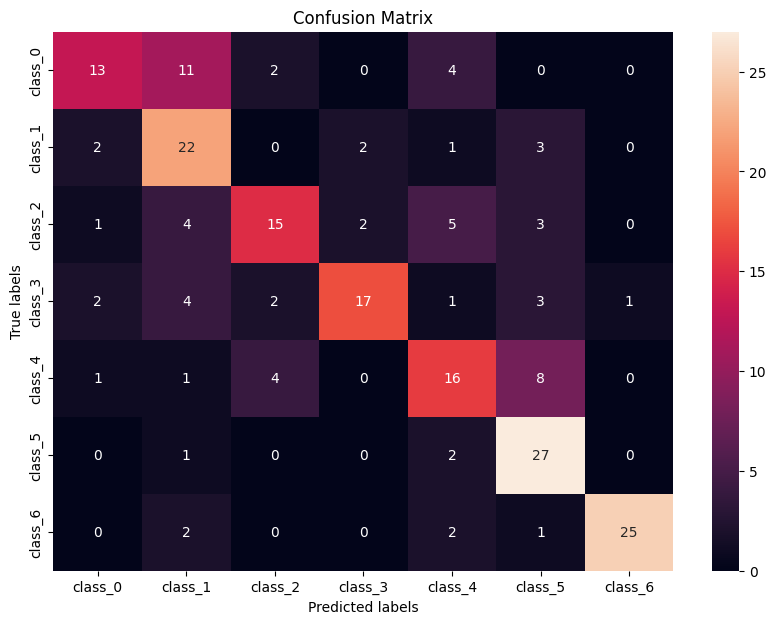

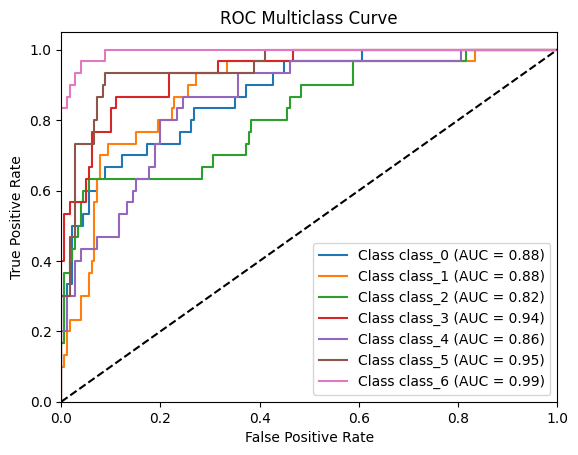

In [25]:
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np # Import the NumPy library

# Set the model to evaluation mode
model_ft.eval()

all_predictions = []
all_labels = []
all_probs = []  # Store probabilities for ROC curve

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_ft(inputs)

        probs = F.softmax(outputs, dim=1)  # Get probabilities
        _, predicted = torch.max(probs, 1)

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Generate a classification report
print(classification_report(all_labels, all_predictions, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# ROC Multiclass Curve
y_test_bin = label_binarize(all_labels, classes=range(num_classes))
y_score = np.array(all_probs)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Multiclass Curve')
plt.legend(loc="lower right")
plt.show()

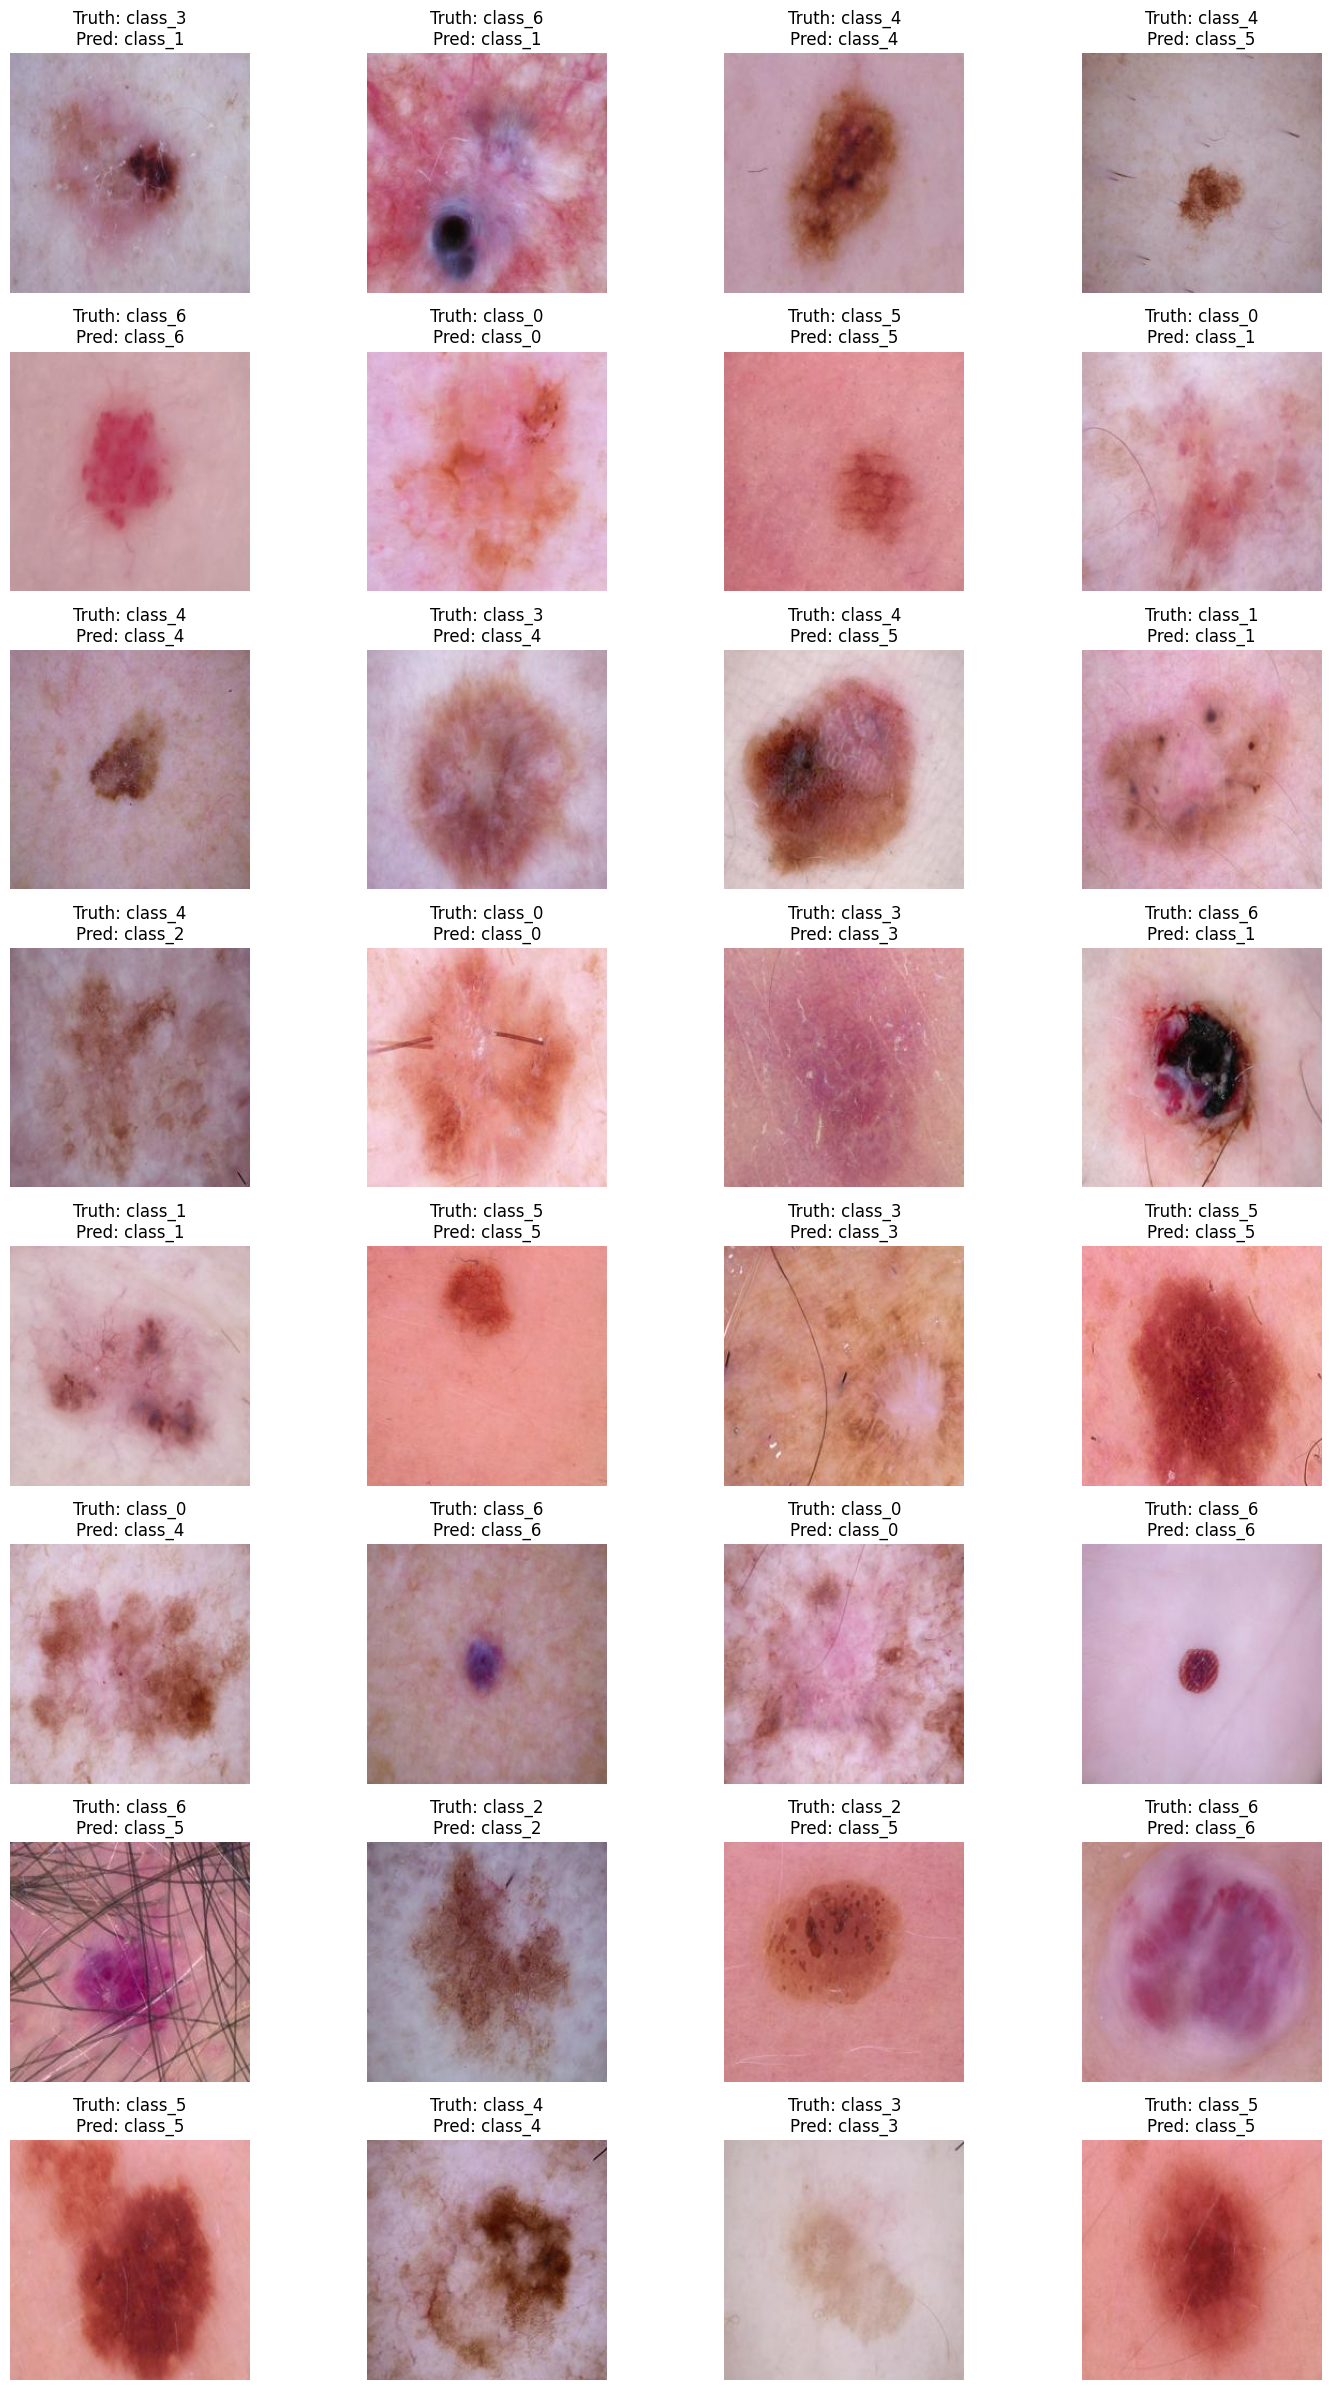

In [30]:
import matplotlib.pyplot as plt

# Get a batch of images
data_iter = iter(dataloaders['test'])
images, labels = next(data_iter)

# Move to CPU if necessary
images = images.cpu()
labels = labels.cpu()

# Get predictions
model_ft.eval()
with torch.no_grad():
    outputs = model_ft(images.to(device))
    _, predicted = torch.max(outputs, 1)
predicted = predicted.cpu()

# Display images with labels and predictions
num_images = len(images)  # Number of images in the batch
num_cols = 4  # Adjust the number of columns as needed
num_rows = (num_images + num_cols - 1) // num_cols  # Calculate number of rows

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))

for i in range(num_images):
    row = i // num_cols
    col = i % num_cols
    image = images[i]
    label = labels[i]
    pred = predicted[i]

    # Denormalize image if necessary (assuming normalization was applied during preprocessing)
    # Replace with your normalization values if different
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    image = image * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)

    # Convert image to numpy and transpose for display
    image_np = image.numpy().transpose((1, 2, 0))

    axes[row, col].imshow(image_np)
    axes[row, col].set_title(f"Truth: {class_names[label]}\nPred: {class_names[pred]}")
    axes[row, col].axis('off')

# Hide any unused subplots
for i in range(num_images, num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [1]:
import matplotlib.pyplot as plt

# Define class names
class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

# Get a batch of images
data_iter = iter(dataloaders['test'])
images, labels = next(data_iter)

# Move to CPU if necessary
images = images.cpu()
labels = labels.cpu()

# Get predictions
model_ft.eval()
with torch.no_grad():
    outputs = model_ft(images.to(device))
    _, predicted = torch.max(outputs, 1)
predicted = predicted.cpu()

# Display images with labels and predictions
num_images = len(images)  # Number of images in the batch
num_cols = 5  # Adjust the number of columns as needed
num_rows = (num_images + num_cols - 1) // num_cols  # Calculate number of rows

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))

for i in range(num_images):
    row = i // num_cols
    col = i % num_cols
    image = images[i]
    label = labels[i]
    pred = predicted[i]

    # Denormalize image if necessary (assuming normalization was applied during preprocessing)
    # Replace with your normalization values if different
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    image = image * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)

    # Convert image to numpy and transpose for display
    image_np = image.numpy().transpose((1, 2, 0))

    axes[row, col].imshow(image_np)
    axes[row, col].set_title(f"Truth: {class_names[label]}\nPred: {class_names[pred]}")
    axes[row, col].axis('off')

# Hide any unused subplots
for i in range(num_images, num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

NameError: name 'dataloaders' is not defined